# Getting Started with the Arize Platform - Investigating Performance Degredation

**In this walkthrough, we are going to investigate a performance drop and get to the bottom of why it happened.**

You manage the fraud detection model for the widely used [Lending Club](https://www.lendingclub.com/). One day you're alerted to a huge spike in customer complaints - people's loans are wrongly being flagged left and right as fraud! Realizing you have no way of investigating this, you turn to Arize to monitor and observe what changed in your previously working fraud detection model.

Our steps to resolving this issue will be :

1. Get our model onto the Arize platform to investigate
2. Setup a performance dashboard to look at prediction accuracy
3. Understand where the model is underperforming
4. Discover the root cause of why a slice (grouping) of predictions is underperforming (teaser - it's drift!)


# Step 0. Setup and Getting the Data
We will load in some preexisting data for the Lending Club fraud detection model - training data, test data, and predictions. Using the preexisting model saves time in this example and also illustrates how simple it is to plug into the Arize platform.
###Install Dependencies and Import Libraries 📚

In [ ]:
!pip install -q arize

import pandas as pd
from arize.utils.types import ModelTypes, Environments
from arize.pandas.logger import Client, Schema
import datetime

# Preparing dataset for this tutorial
datasets = {}
url = "https://storage.googleapis.com/arize-assets/fixtures/value_showcase"
for env in ["training", "validation", "production", "shap"]:
    datasets[env] = pd.read_csv(f"{url}/{env}.zip")

datasets["production"]["model_date"] = pd.to_datetime(datasets["production"]["model_date"])
shap_df = datasets["shap"]

print("✅ Dependencies installed and data successfully downloaded!")

# Step 1. Sending Data into Arize 💫

Now that we have our data configured, we are ready to integrate into Arize. We do this by logging (sending) important data we want to analyze to the platform. There, the data will be easily visualized and investigated to source our problem.

For our model, we are going to log:


*   feature data
*   predictions
*   actuals
*   SHAP values for explainability metrics

## Import and Setup Arize Client

The first step is to setup our Arize client. After that we will log the data.

First, copy the Arize `API_KEY` and `SPACE_KEY` from your admin page shown below! Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.




<img src="https://storage.googleapis.com/arize-assets/fixtures/copy-keys.png" width="700">

In [ ]:
SPACE_KEY = "SPACE_KEY"
API_KEY = "API_KEY"
arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)

model_id = "analyzing-performance-degredation"  # This is the model name that will show up in Arize
model_version = "v1.0"  # Version of model - can be any string
model_type = ModelTypes.SCORE_CATEGORICAL

if SPACE_KEY == "SPACE_KEY" or API_KEY == "API_KEY":
    raise ValueError("❌ NEED TO CHANGE SPACE AND/OR API_KEY")
else:
    print("✅ Arize setup complete!")

## Log Training & Validation Data
Now that our Arize client is setup, let's go ahead and log all of our data to the platform. For more details on how **`arize.pandas.logger`** works, visit out documentations page below.

[![Buttons_OpenOrange.png](https://storage.googleapis.com/arize-assets/fixtures/Buttons_OpenOrange.png)](https://docs.arize.com/arize/sdks-and-integrations/python-sdk/arize.pandas)

In [ ]:
# This is the data which we will be logging
val_df = datasets["validation"]
train_df = datasets["training"]
feature_column_names = ["loan_amount", "term", "interest_rate", "installment", "grade", "home_ownership", "annual_income",
                        "verification_status", "pymnt_plan", "purpose", "addr_state", "dti", "delinq_2yrs", "inq_last_6mths", "mths_since_last_delinq",
                        "mths_since_last_record", "open_acc", "pub_rec", "revol_bal", "revol_util","total_acc", "fico_score", "fico_range"
                        ]

# Define a Schema() object for Arize to pick up data from the correct columns for logging
schema = Schema(
    prediction_id_column_name="prediction_ids",
    prediction_label_column_name="predictions",
    prediction_score_column_name="predictions_score",
    actual_label_column_name="actuals",
    # feature_column_names should be specific to your model
    feature_column_names=feature_column_names,
)

# Logging Training DataFrame
train_response = arize_client.log(
    dataframe=datasets["training"],
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    environment=Environments.TRAINING,
    schema=schema,
)

# Logging Validation DataFrame
val_response = arize_client.log(
    dataframe=datasets["validation"],
    model_id=model_id,
    model_version=model_version,
    batch_id="val",
    model_type=model_type,
    environment=Environments.VALIDATION,
    schema=schema,
)

# If successful, the server will return a status_code of 200
if val_response.status_code != 200 or train_response.status_code != 200:
    print(f"❌ logging failed with response code {train_response.status_code}, {train_response.text}")
    print(f"❌ logging failed with response code {val_response.status_code}, {val_response.text}")
else:
    print(f"✅ You have successfully logged validation set to Arize")

## Log the Production Data
Similarly, we will use the `arize.pandas.logger` to log the production dataset. Here, we will need to add 
1. A `prediction_ts` column to our DataFrame and a `timestamp_column_name` argument to our schema to set time for our model.
2. A `feature_name_shap` column for each feature, as well as a dictionary mapping names of features column names to their shap column names.


In [ ]:
# We need to redefine schema since we added prediction_ts column for production timeline
datasets['production'] = datasets['production'] # we ignore a subset of our prod data for this tutorial
time_offset = datetime.datetime.now() - datasets['production']["model_date"].max()
datasets['production']["prediction_ts"] = datasets['production']["model_date"].apply(lambda t: (t + time_offset).timestamp())

# We also need to log SHAP values, so we need to insert the shap columns into our df for pandas logger 
shap_values_column_names = {} # k-v mapping 'feature_name' to 'feature_name_shap' in df
for column_name in shap_df.columns:
    shap_column_name = column_name + '_shap'
    # Creating a mapping from feature column name to shap column name for Schema()
    shap_values_column_names[column_name] = shap_column_name
    # Adding the shap content to our production_df 
    datasets['production'][shap_column_name] = shap_df[column_name]

# Define a Schema() object for Arize to pick up data from the correct columns for logging
production_schema = Schema(
    prediction_id_column_name="prediction_ids",
    feature_column_names=feature_column_names,
    timestamp_column_name="prediction_ts",
    prediction_label_column_name="predictions",
    prediction_score_column_name="predictions_score",
    actual_label_column_name="actuals",
    shap_values_column_names=shap_values_column_names
)

# arize_client.log returns a Response object from Python's requests module
prod_response = arize_client.log(
    dataframe=datasets["production"],
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    environment=Environments.PRODUCTION,
    schema=production_schema,
)

# If successful, the server will return a status_code of 200
if prod_response.status_code != 200:
    print(f"❌ logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged production set to Arize")

## Check Data Ingestion Information

Data will be available in the UI in about 10 minutes after it was received. If data from a new model is sent, the model will be reflected almost immediately in the Arize platform. However, you will not see data yet. To verify data has been sent correctly and is being processed, we recommend that you check our Data Ingestion tab. 

You will be able to see the predictions, actuals, and feature importances that have been sent in the last week, last day or last 30 minutes. 

An example view of the Data Ingestion tab from a model, when data is sent continuously over 30 minutes, is shown in the image below. 

<img src="https://storage.googleapis.com/arize-assets/fixtures/data-ingestion-tab.png" width="700">

# Coffee Time! ☕️
Note that the Arize performs takes about 10 minutes to index the data. While the model should appear immediately, the data will not show up till the indexing is done. Feel free to go grab a cup of coffee as Arize works its magic! 🔮

**⚠️ DON'T SKIP:**
In order to move on to the next step, make sure your actuals and training/validation sets are loaded into the platform. To check:
1. On the **Overview Tab** make sure you see the actuals as shown below.
2. Actual data will show up under **Model Health**. Once the number changes from **0 Actuals** to **Actuals** (with summary statistics such as cardinality listed in the drop-down), your production actuals will have been fully recorded on Arize!

![image.png](https://storage.googleapis.com/arize-assets/fixtures/waiting-on-data.png)

![image.png](https://storage.googleapis.com/arize-assets/fixtures/waiting-on-actual-data.png)

# Step 2. Monitor Performance of Model
Welcome back! Now we can go take a look at the Arize platform and figure out how our model is performing. Head over to the Models page and select our newly created model `lending-club-tutorial`. 

Let's set up a performance monitor to see how our model is doing. We can do those quickly from the `Overview` page by fill out the performance monitor according the following:

| Field      | Value |
| ----------- | ----------- |
| Trigger Alert When   | Accuracy is below    |
| Value   | 0.4   |

![image.png](https://storage.googleapis.com/arize-assets/fixtures/performance_degradation_setup.gif)

Arize offers a variety of metrics to monitor, and in this example we will be tracking the accuracy. When the accuracy dips below 0.4, the monitor will trigger and you will know to investigate the performance issue. Additionally, you can enter an email address under *Send Trigger Notification to* to alert someone by email when the monitor fires.

# Step 3. Analyze where Performance is Low
Now that we've identified there is indeed performance degredation, let's do a deeper dive into where it's happening. Arize is great at slicing and dicing data by feature in order to pinpoint where metrics are dipping. One tool to do that is the Feature Performance Heatmap.

The heatmap tells you what the accuracy is for different slices - which are groupings of predictions based on one or more features. This is illustrated through color, where **Red indicates an underperforming slice, and yellow indicates a good performing slice.** Let's try it out!

Steps:
1. Head over to the **Dashboards** Tab of your model'
2. Click Create Dashboard
3. Select All Features
4. Make sure you have Accuracy as your selected metric


![image.png](https://storage.googleapis.com/arize-assets/fixtures/performance_degradation_dashboard_setup.gif)

### Viewing Performance Slices
**Performance Slices** are subsets of your dataset selected based on the values of your features. It is useful for honing down on values where your model is low performing.

Select the **Show Performance Slices** button in the top right corner. You can easily find the worst performing slices ranked worst to best. Here we can see that `pawn_shop_loan` is significantly low performing.

![image.png](https://storage.googleapis.com/arize-assets/fixtures/performance_degradation_show_performance_slices.gif)

Scroll down to the worst performing slice.  We can see where the *purpose* is `pawn_shop_loan` performs the worst. A quick glance at it reveals a huge disparity between the accuracy for `pawn_shop_loan` and `debt_consolidation`.

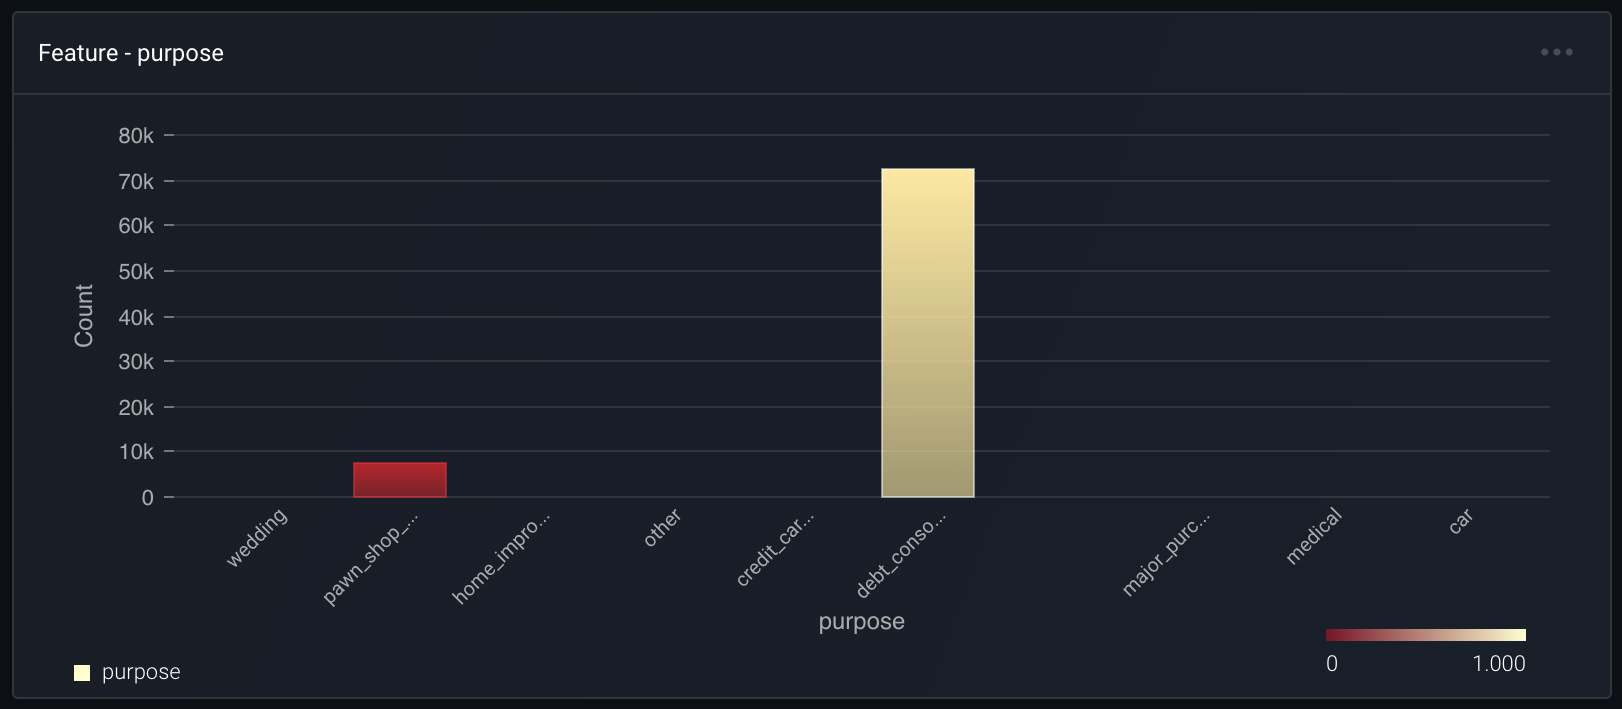


**Congratulations!** 🎉   We tracked down the source of the performance degredation to the data slice where purpose = `pawn_shop_loan`. With this knowledge, we are very close to figuring out exactly the root cause of why our customers are experiencing loan issues. Only the following questions remain.

*Why is this happening? Has this feature drifted? Is there a data quality issue?* Let's get to the bottom of this.

# Step 4. Check if Feature has Drifted

Now that we have identified a single slice being responsible for the performance degredation, let's begin our investigation of what's driving it. One possible root cause is feature drift, which can cause models to suddenly start giving innacurate predictions.

#### A. Set up a Baseline

Before we can look at drift, we need to set up a baseline to compare our model to. Go ahead and click on the **Configure** button in the bottom popup, or by going to the **Baseline** button on the right side of the screen. We're going to set our training data as our baseline. Click **Set as Baseline** under Actions on the training data row, and hit **Confirm** when the popup appears.

![configure-baseline.gif](https://storage.googleapis.com/arize-assets/fixtures/configure-baseline-v2.gif)



#### B. Creating a Feature Drift Monitor

Head back to the **Model Overview** Tab. Arize allows easy creation of drift monitors for all features using the plus button next to **Drift** on the right side of the screen. Go ahead and press that to set up the drift monitors, which will include the one we are after, the *purpose* feature drift monitor.

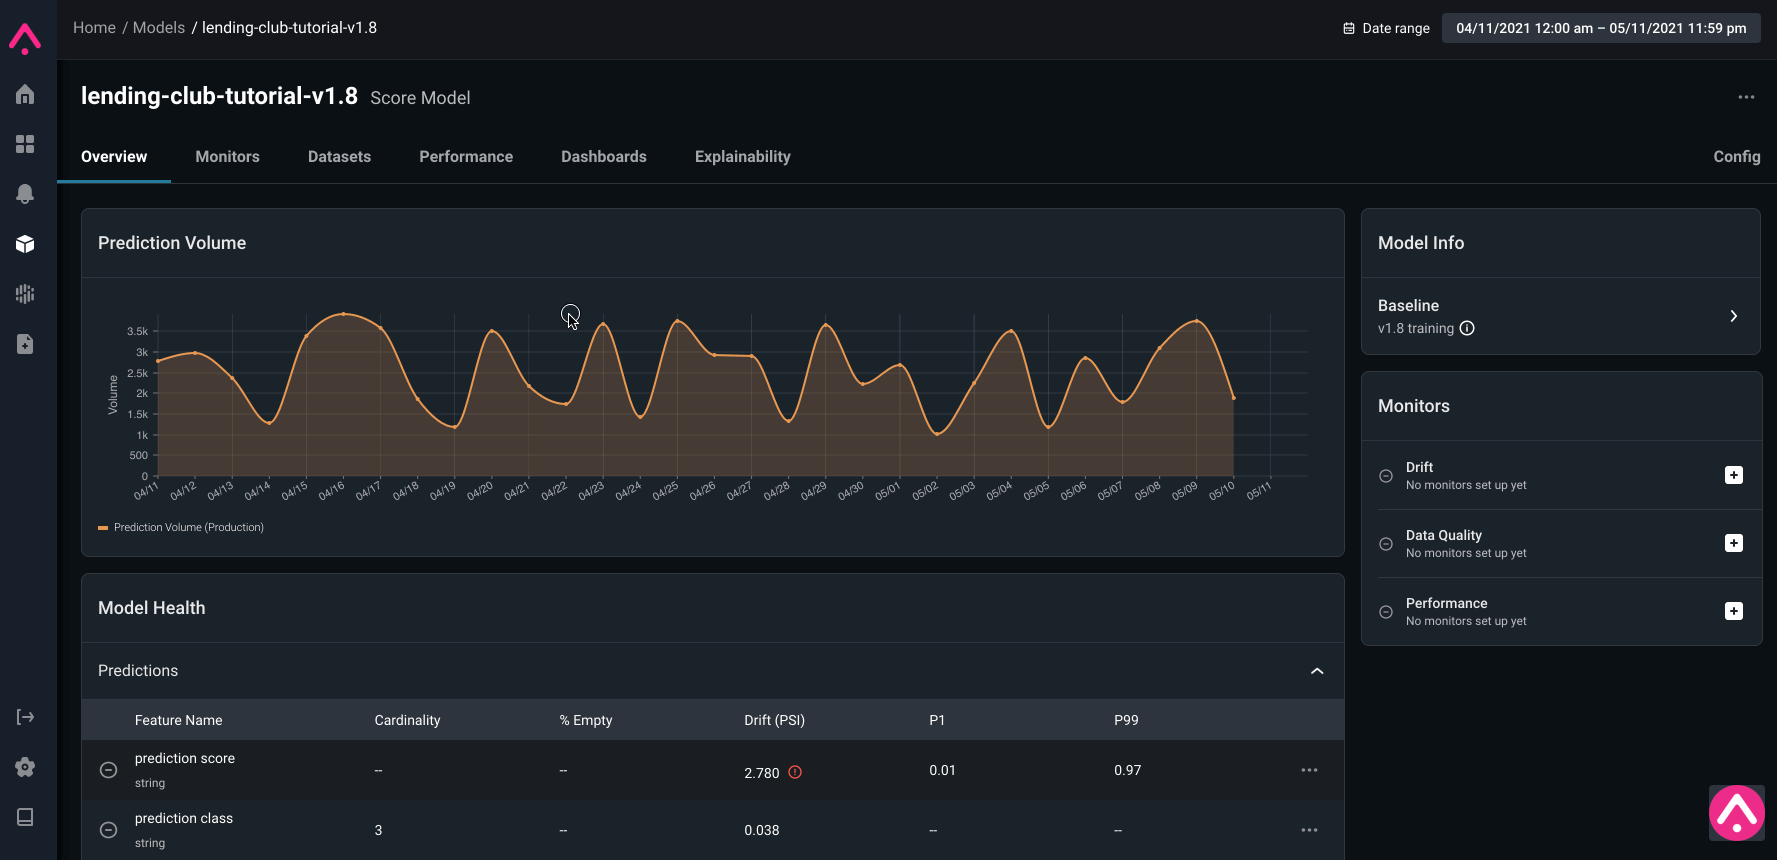

Now that the monitor is setup, let's go and check it out. Clicking on it takes you to a visualization of the feature timeseries, as well as a place to edit the monitor. We demonstrate how email alerts can be setup for when the monitor is triggered.

Make sure you select the `purpose` feature, which we identified as the low performance feature slice `pawn_shop_loan`.

![image.png](https://storage.googleapis.com/arize-assets/fixtures/performance_degradation_show_purpose.gif)

From this monitor, you can clearly see that the purpose feature has drifted a lot, explaining why the slice `purpose = pawn_shop_loan` has been performing so poorly. With this, we finally have actionable information. Addressing the spike in loans made out to pawn shops is where our solution lies. Looking forward, with the monitor set up to notify us of future drift, we can stay on top of our model's performance in the future.

# Wrap Up 🎁

In this walkthrough we've shown how Arize can be used to log prediction data for a model, pinpoint model performance degredation, and set up monitors to catch future issues. Though we covered a lot of ground, this is just scratching the surface of what the Arize platform can do. We urge you to explore more of Arize, either on your own or through one of our many other tutorials.

### Overview
Arize is an end-to-end ML observability and model monitoring platform. The platform is designed to help ML engineers and data science practitioners surface and fix issues with ML models in production faster with:
- Automated ML monitoring and model monitoring
- Workflows to troubleshoot model performance
- Real-time visualizations for model performance monitoring, data quality monitoring, and drift monitoring
- Model prediction cohort analysis
- Pre-deployment model validation
- Integrated model explainability

### Website
Visit Us At: https://arize.com/model-monitoring/

### Additional Resources
- [What is ML observability?](https://arize.com/what-is-ml-observability/)
- [Playbook to model monitoring in production](https://arize.com/the-playbook-to-monitor-your-models-performance-in-production/)
- [Using statistical distance metrics for ML monitoring and observability](https://arize.com/using-statistical-distance-metrics-for-machine-learning-observability/)
- [ML infrastructure tools for data preparation](https://arize.com/ml-infrastructure-tools-for-data-preparation/)
- [ML infrastructure tools for model building](https://arize.com/ml-infrastructure-tools-for-model-building/)
- [ML infrastructure tools for production](https://arize.com/ml-infrastructure-tools-for-production-part-1/)
- [ML infrastructure tools for model deployment and model serving](https://arize.com/ml-infrastructure-tools-for-production-part-2-model-deployment-and-serving/)
- [ML infrastructure tools for ML monitoring and observability](https://arize.com/ml-infrastructure-tools-ml-observability/)

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.
